# **Estudos sobre detecção de Fraude**

## Informações sobre os dados utilizados

Durante meus estudos foi utilizada a base [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) disponível no Kaggle.<p>
Esse dataset contém transações realizadas em Setembro de 2013 por Europeus.<br>
O dataset apresenta transações ocorridas em dois dias, aonde tiveram 492 fraudes de 284,807 transações. O dataset é altamente desbalanceado, as fraudes representam 0.172% de todas as transações.<p>
Esse dataset contém apenas campos numéricos que são resultado de uma transformação PCA.

## Import das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import PrecisionRecallDisplay, make_scorer, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
sns.set_theme()

## Carregamento dos dados

In [3]:
transactions = pd.read_csv('creditcard.csv')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
transactions.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

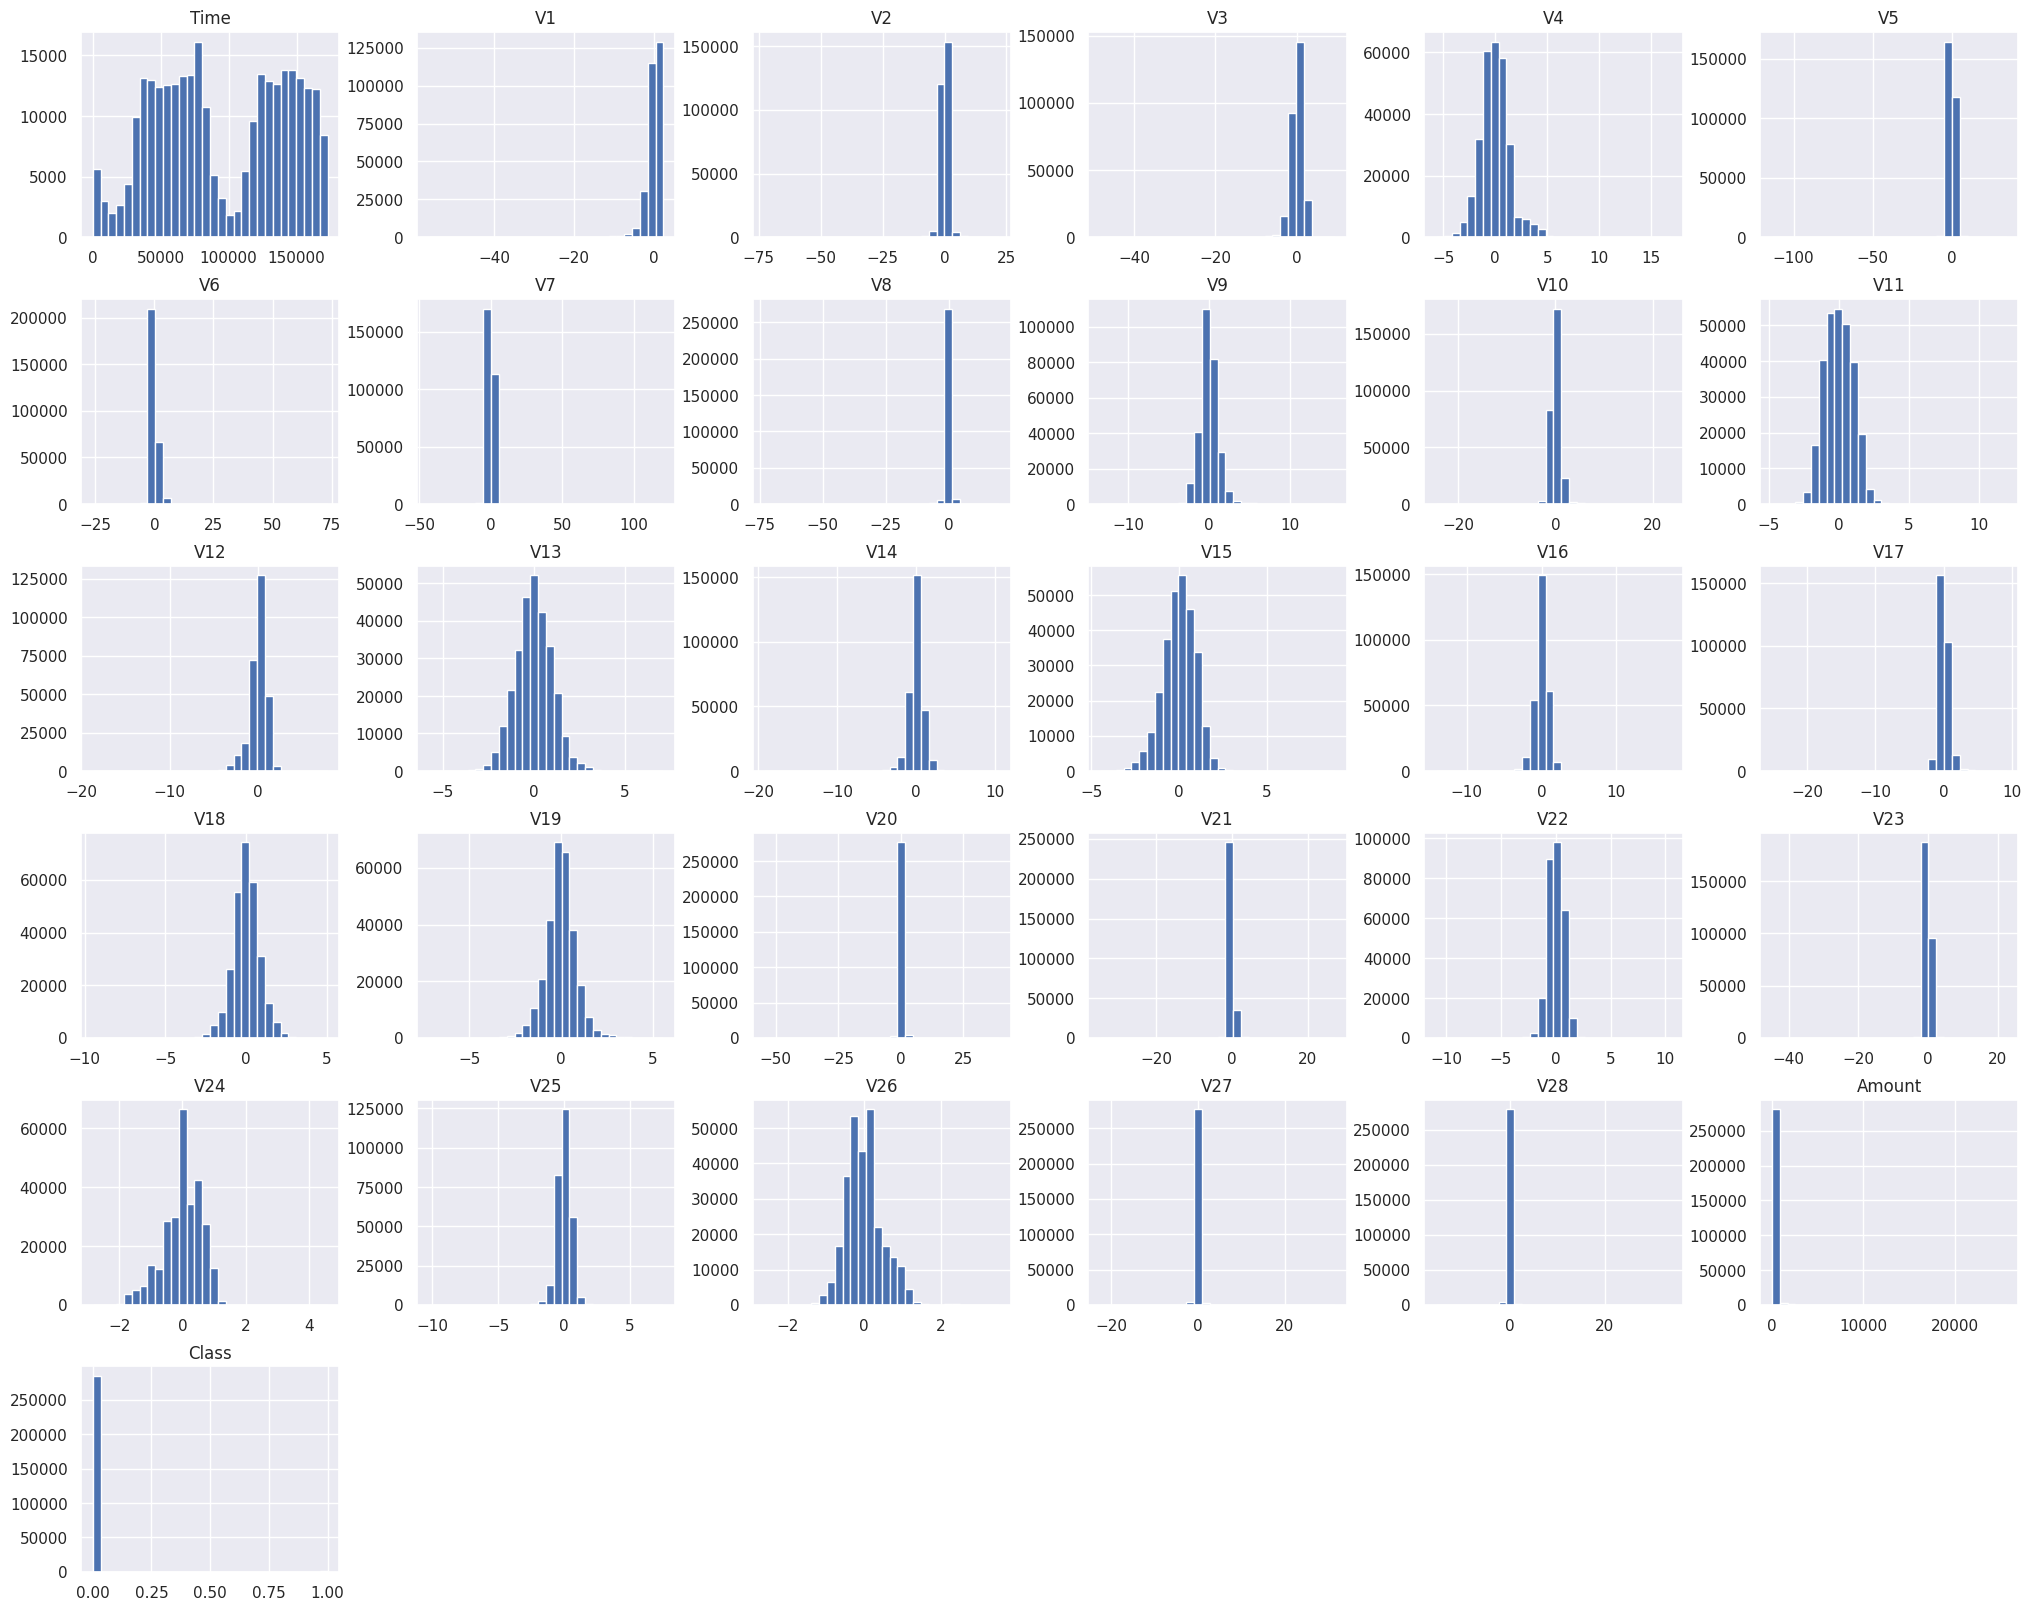

In [5]:
transactions.hist(figsize=(25,20), bins=30)
plt.show()

<Axes: >

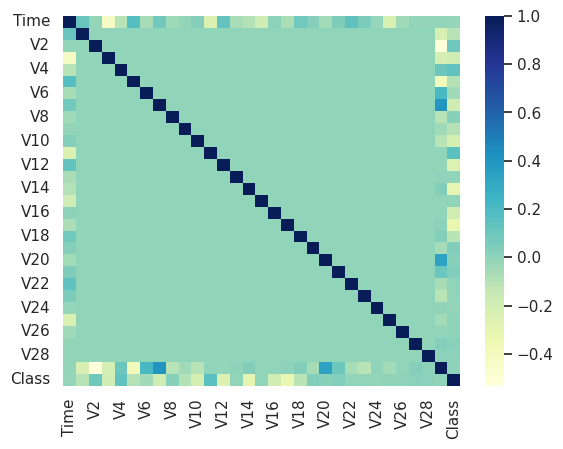

In [6]:
sns.heatmap(transactions.corr(), cmap='YlGnBu')

## Tratamento dos dados

In [7]:
# A diferença de tempo entre as transações não parece relevante (seria se tivessemos como identificar cada um dos usuários) portanto irei remover a coluna
transactions.drop(columns=['Time'], inplace=True)

In [8]:
# Podemos observar que existe uma diferença de valores muito grande entre as variáveis geradas por PCA e a coluna Amount (o que pode afetar o desempenho do modelo), portanto aplicarei uma padronização
X = transactions.iloc[:, :-1]
y = transactions.iloc[:, -1]

sc = StandardScaler()
X = sc.fit_transform(X)

In [9]:
# Vou separar os dados em treino e teste para validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo 1 - Random Tree Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=30, random_state=42)
scores_rt = cross_validate(rf, X, y, scoring='average_precision', n_jobs=-1, cv=5)

scores_table = pd.DataFrame({'random_forest_precision':scores_rt['test_score']})

In [11]:
rf_model = rf.fit(X_train, y_train)

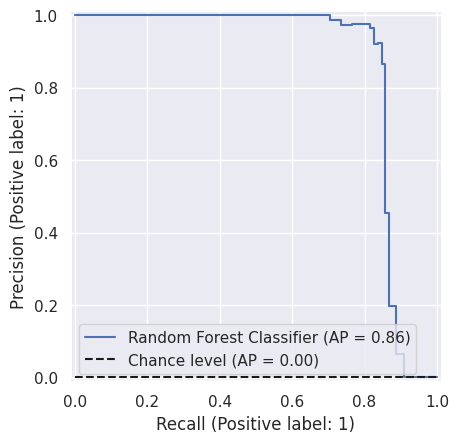

In [12]:
display_random_tree = PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, name='Random Forest Classifier', plot_chance_level=True, despine=True)

## Modelo 2 - Regressão Logística

In [13]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=42)
lg_weight = LogisticRegression(random_state=42, class_weight={0:0.20,  1:0.80})
lg_balanced = LogisticRegression(random_state=42, class_weight='balanced')

scores = cross_validate(lg, X, y, scoring='average_precision', n_jobs=-1, cv=5)
scores_weight = cross_validate(lg_weight, X, y, scoring='average_precision', n_jobs=-1, cv=5)
scores_balanced = cross_validate(lg_balanced, X, y, scoring='average_precision', n_jobs=-1, cv=5)

scores_table_2 = pd.DataFrame({'logistic_precision':scores['test_score'], 'weighted_precision':scores_weight['test_score'], 'balanced_precision':scores_balanced['test_score']})

In [14]:
scores_table_final = pd.concat([scores_table, scores_table_2], axis=1, ignore_index=False, sort=False)
scores_table_final.mean()

random_forest_precision    0.773639
logistic_precision         0.743782
weighted_precision         0.764097
balanced_precision         0.751042
dtype: float64

In [15]:
logistic_balanced_model = lg_balanced.fit(X_train, y_train)

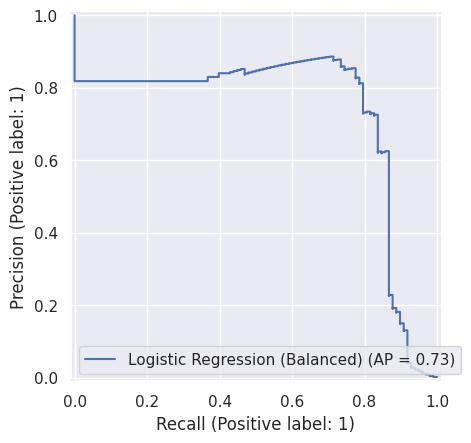

In [16]:
display_logistic_balanced = PrecisionRecallDisplay.from_estimator(lg_balanced, X_test, y_test, name='Logistic Regression (Balanced)', despine=True)

In [17]:
logistic_weighted_model = lg_weight.fit(X_train, y_train)

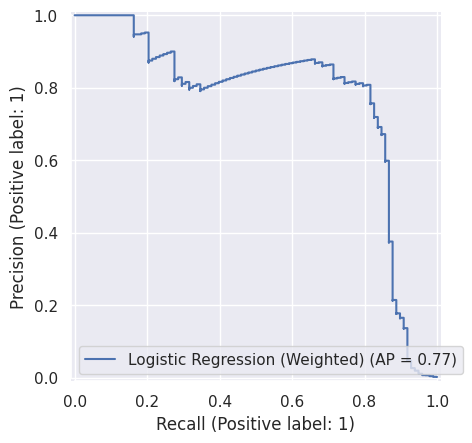

In [18]:
display_logistic_weighted = PrecisionRecallDisplay.from_estimator(lg_weight, X_test, y_test, name='Logistic Regression (Weighted)', despine=True)

In [19]:
logistic_model = lg.fit(X_train, y_train)

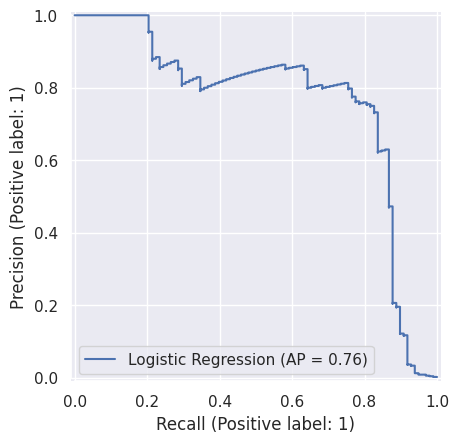

In [20]:
display_logistic = PrecisionRecallDisplay.from_estimator(lg, X_test, y_test, name='Logistic Regression', despine=True)

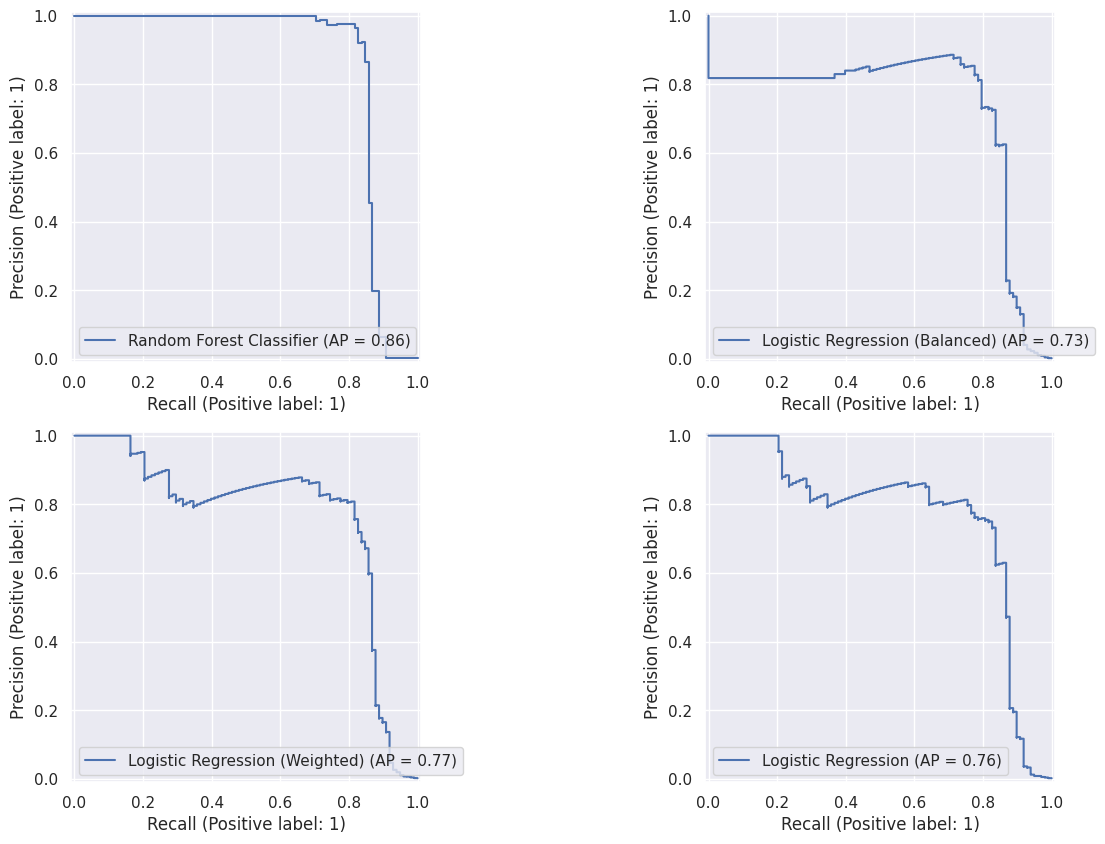

In [21]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
display_random_tree.plot(ax=ax[0,0])
display_logistic_balanced.plot(ax=ax[0,1])
display_logistic_weighted.plot(ax=ax[1,0])
display_logistic.plot(ax=ax[1,1])
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV

rf_optimization = RandomForestClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [30, 60, 100],
    'class_weight': [{0:0.2, 1:0.8}, {0:0.15, 1:0.85}, None]
}

search = GridSearchCV(rf_optimization, param_grid=param_grid, scoring='average_precision', n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.2, 1: 0.8}, {0: 0.15, 1: 0.85},
                                          None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [30, 60, 100]},
             scoring='average_precision')

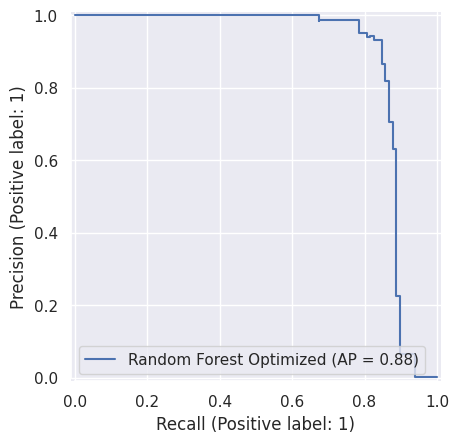

In [27]:
rf_optimized = RandomForestClassifier(random_state=42, class_weight=search.best_estimator_.class_weight, max_depth=search.best_estimator_.max_depth, criterion=search.best_estimator_.criterion)
rf_optimized_model = rf_optimized.fit(X_train, y_train)
display_rf_optimized = PrecisionRecallDisplay.from_estimator(rf_optimized_model, X_test, y_test, name='Random Forest Optimized', despine=True)

In [25]:
search.best_estimator_.criterion

'entropy'